In [1]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append("../DeepGaze")
from scipy.ndimage import zoom
from scipy.special import logsumexp
from scipy.io import savemat
import torch
import matplotlib.image as mpimg
sys.path.append("../DeepGaze")
import deepgaze_pytorch
import cv2

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from image_processing.utils import read_video
from image_processing.computational_models import compute_dg_saliency
from general_utils.utils import print_wise


In [4]:
# if torch.cuda.is_available():
#     device = "cuda"
# elif torch.backends.mps.is_available():
#     device = "mps"
# else:
#     device = "cpu"
# # end if torch.cuda.is_available():

In [5]:
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True)
compute_dg_saliency(paths, 1, "IMG_4704.mp4", model, .1)

Loaded pretrained weights for efficientnet-b5


KeyboardInterrupt: 

In [ ]:
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True)
compute_dg_saliency(paths, 1, "IMG_4704.mp4", model, .1)

Loaded pretrained weights for efficientnet-b5


Using cache found in /Users/tizianocausin/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /Users/tizianocausin/.cache/torch/hub/pytorch_vision_v0.6.0


08:08:16 - rank 1 IMG_4704.mp4 read successfully
08:08:35 - frame 0 computed
08:08:44 - frame 1 computed


KeyboardInterrupt: 

In [51]:
fn = "IMG_4664.mp4"
vid = read_video(paths, 1, fn)

17:46:12 - rank 1 IMG_4664.mp4 read successfully


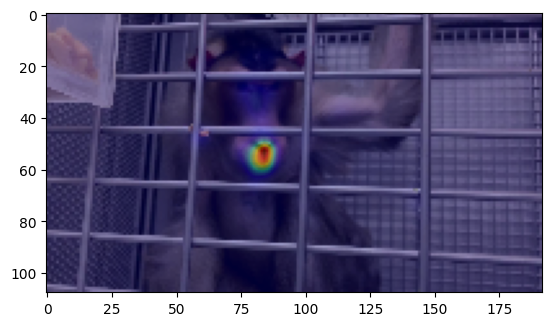

In [18]:
from scipy.io import loadmat
features = loadmat(f"/Volumes/LivingstoneLab/tiziano/models/dgIIE_{fn[:-4]}.mat")['features']
features_map = features.reshape(108, 192,5, order="F")
plt.imshow(cv2.resize(vid[0,:,:,:],(192, 108)))
plt.imshow(features_map[:,:,0], alpha=0.4, cmap='jet')

In [ ]:

image_data = vid[100,:,:,:]



'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


In [ ]:
import tensorflow.compat.v1 as tf

def ICF_setup(paths):
    tf.reset_default_graph()
    tf.disable_v2_behavior()
    check_point = f"{paths['livingstone_lab']}/tiziano/model_weights/deep_gaze/ICF.ckpt"  # DeepGaze II
    new_saver = tf.train.import_meta_graph('{}.meta'.format(check_point))
    input_tensor = tf.get_collection('input_tensor')[0]
    # in case we wanted the center bias
    # centerbias_tensor = tf.get_collection('centerbias_tensor')[0]
    # log_density = tf.get_collection('log_density')[0]
    log_density_wo_centerbias = tf.get_collection('log_density_wo_centerbias')[0]
    return check_point, new_saver, input_tensor, log_density_wo_centerbias


"""
preprocess_log_density
First it brings the log density into probability mass, and then it reduces the size of the PMF, 
renormalizes and flattens according to matlab's order
"""
def preprocess_log_density(log_density_prediction, new_dims):
    if type(log_density_prediction) !=  np.ndarray:
        log_density_prediction = log_density_prediction.numpy()
    pmf = np.exp(log_density_prediction)/np.sum(np.exp(log_density_prediction))
    log_density_prediction = cv2.resize(log_density_prediction.squeeze(), new_dims)
    pmf_flat = pmf.flatten(order="F")
    return pmf_flat


def compute_ICF_saliency(paths, rank, fn, check_point, new_saver, input_tensor, log_density_wo_centerbias):
    outfn = f"{paths['livingstone_lab']}/tiziano/models/ICF_{fn[:-4]}.mat" # [:-4] slice to take off the mp4 extension
    if os.path.exists(outfn):
        print_wise(f"model already exists at {outfn}", rank=rank)
        return None
    else:
        # check_point, new_saver, input_tensor, log_density_wo_centerbias = ICF_setup(paths)
        video = read_video(paths, rank, fn, vid_duration=0)
        features = ICF_loop(video, check_point, new_saver, input_tensor, log_density_wo_centerbias)
        np.savez_compressed(outfn, data=features)
        print_wise(f"model saved at {outfn}", rank=rank)


    def ICF_loop(video, resize_factor, check_point, new_saver, input_tensor, log_density_wo_centerbias):
        with tf.Session() as sess:
            new_saver.restore(sess, check_point)
            h, w = video.shape[1:3] 
            new_dims = (round(w*resize_factor), round(h*resize_factor))
            video_saliency = []
            for i_frame in range(3):
                input = video[i_frame, :,:,:]
                log_density_prediction = sess.run(log_density_wo_centerbias, {
                input_tensor: input[np.newaxis, :,:,:],
                })
                d_flat = preprocess_log_density(log_density_prediction, new_dims)
                video_saliency.append(d_flat)
            # end for i in range(3):
        # end with tf.Session() as sess:
        video_saliency = np.stack(video_saliency, axis=1)
        return video_saliency

                

INFO:tensorflow:Restoring parameters from /Volumes/LivingstoneLab/tiziano/model_weights/deep_gaze/ICF.ckpt


In [47]:
a = np.load("/Volumes/LivingstoneLab/tiziano/models/ICF_IMG_4664.npz")

In [49]:
a['data'].shape

(20736, 2)

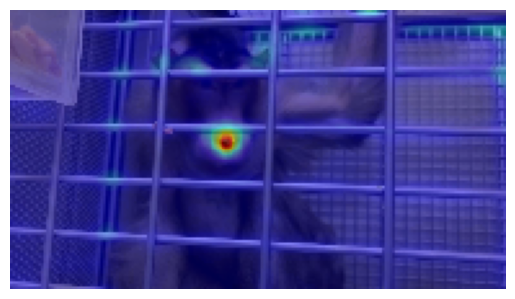

In [53]:
plt.imshow(cv2.resize(vid[0,:,:,:], (192, 108)), alpha=1)             # background image
plt.imshow(a['data'][:,0].reshape(108, 192, order="F"), cmap='jet', alpha=.5)  # semi-transparent heatmap overlay
plt.axis('off')
plt.show()